## Prediction of Gout from patient's Chief Complaint Corpa

## Question: Is this patient potentially in need of treatment for Gout?

##  Data
The data is found in the MIMIC-III (Medical Information Mart for Intensive Care III) database.  Details can be found at https://physionet.org/content/emer-complaint-gout/1.0/.   Acces to the database may be requested at (https://mimic.physionet.org/gettingstarted/access/).  The data is contained in 2 csv files from years 2019 and 2020.

### Import Data

In [1]:
import pandas as pd
df = pd.read_pickle("noGoutTerm.csv")
df.shape

(8275, 2)

### Split data into training and test sets

In [2]:
from sklearn.model_selection import train_test_split, GridSearchCV, KFold
    
    # split data into training and validation sets
X_train, X_test, y_train, y_test = train_test_split(df['corpus'], df.target, test_size=0.30, random_state=55)

###  Convert training data to integer vectors with TF-IDF, weighted, by importance.

In [3]:
import numpy as np
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.preprocessing import LabelEncoder

    # Vectoring the corpus from string to int
tfidf_vectorizer = TfidfVectorizer(stop_words='english')
X_train = tfidf_vectorizer.fit_transform(X_train)
X_test = tfidf_vectorizer.transform(X_test)

### Encode the test target values

In [4]:
labelencoder=LabelEncoder()
E_y_test = labelencoder.fit_transform(y_test)

## Instantiate Models

In [30]:
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import GradientBoostingClassifier
from sklearn.naive_bayes import MultinomialNB
from sklearn import svm
from sklearn.neighbors import KNeighborsClassifier
from sklearn.ensemble import RandomForestClassifier

# Models
models_untuned = [
{
    'label': 'Logistic Regression',
    'model': LogisticRegression(random_state=13)
},
    
{   'label': 'Gradient Boosting',
    'model': GradientBoostingClassifier()
},
    
{   'label' : 'Naive Bayes',
    'model' : MultinomialNB()},
    
{   'label' : 'SVM',
    'model' : svm.SVC()
},
    
{   'label' : 'Random Forest',   
     'model' : RandomForestClassifier()
},
{   'label' : 'KNNeighbors',     
    'model' : KNeighborsClassifier()
}
]

## Create Methods

### Method: fit_model
Returns roc_auc score, uses over/under sampling to balance the classes

In [10]:
from sklearn import metrics
import matplotlib.pyplot as plt
import imblearn
from imblearn.pipeline import make_pipeline, Pipeline
from numpy import mean
from imblearn.over_sampling import RandomOverSampler
from imblearn.under_sampling import RandomUnderSampler
from sklearn.model_selection import RepeatedStratifiedKFold

In [36]:
from sklearn.model_selection import RandomizedSearchCV
import warnings
warnings.filterwarnings('ignore')
def fit_models(model, param_grid):
    over = RandomOverSampler(sampling_strategy=0.1)
    under = RandomUnderSampler(sampling_strategy=0.5)
    steps = [('o', over), ('u', under), ('m', model['model'])]
    pipeline = Pipeline(steps=steps)
    cv = RepeatedStratifiedKFold(n_splits=10, n_repeats=3, random_state=0)
    grid = GridSearchCV(pipeline, param_grid, scoring='roc_auc', cv=cv)
    grid.fit(X_train, y_train)
    if model['label'] == 'SVM':
        predict = grid.decision_function(X_test)
    else:
        predict = grid.predict_proba(X_test)[:, 1]
    score = metrics.roc_auc_score(y_test, predict)
    return score, grid

### Method to plot ROC_AUC
Plots all models on single plot

In [46]:
from sklearn import metrics
import matplotlib.pyplot as plt

def ROC_overlap(models, param_grid):
    plt.figure(figsize=(11,5))
    allAUC = []

# Below for loop iterates through your models list
    for m in models:
        model = m['model'] # select the model
        over = RandomOverSampler(sampling_strategy=0.1)
        under = RandomUnderSampler(sampling_strategy=0.5)
        steps = [('o', over), ('u', under), ('m', model)]
        pipeline = Pipeline(steps=steps)
        cv = RepeatedStratifiedKFold(n_splits=10, n_repeats=3, random_state=0)
        grid = GridSearchCV(pipeline, param_grid, scoring='roc_auc', cv=cv)

        if m['label'] == 'SVM':
            test_predict_label = grid.fit(X_train, y_train).decision_function(X_test)
            fpr, tpr, threshold = metrics.roc_curve(E_y_test, test_predict_label)
        else:
            grid.fit(X_train, y_train) # train the model
            y_pred=grid.predict(X_test) # predict the test data
            fpr, tpr, thresholds = metrics.roc_curve(E_y_test, grid.predict_proba(X_test)[:,1])
        auc = metrics.auc(fpr,tpr)
        allAUC.append(auc)

# Now, plot the computed values
        plt.plot(fpr, tpr, label='%s ROC (area = %0.2f)' % (m['label'], auc))
# Custom settings for the plot 
    plt.plot([0, 1], [0, 1],'r--')
    plt.xlim([0.0, 1.0])
    plt.ylim([0.0, 1.05])
    plt.xlabel('1-Specificity(False Positive Rate)')
    plt.ylabel('Sensitivity(True Positive Rate)')
    plt.title('Receiver Operating Characteristic')
    plt.legend(loc="lower right")
    plt.show()   # Display

### Method: plotConfusion
plots the confustion matrix for each model

In [19]:

from sklearn.metrics import confusion_matrix
import seaborn as sns

def plotConfusion(models):
    for m in models:
        model = m['model'] # select the model
        over = RandomOverSampler(sampling_strategy=0.1)
        under = RandomUnderSampler(sampling_strategy=0.5)
        steps = [('o', over), ('u', under), ('m', model)]
        pipeline = Pipeline(steps=steps)
        cv = RepeatedStratifiedKFold(n_splits=10, n_repeats=3, random_state=0)
        model = GridSearchCV(pipeline, param_grid, scoring='roc_auc', cv=cv)
        model.fit(X_train, y_train) # train the model
        prediction = model.predict(X_test)
        mat = confusion_matrix(y_test, prediction)
        sns.heatmap(mat.T, square=True, annot=True, fmt='d', cbar=False)
        plt.title(m['label'])
        plt.xlabel('true')
        plt.ylabel('predicted')
        plt.show()

## Train and Test Models

### Untuned models are trained and tested, roc auc scores are displayed below

In [37]:
grid = {}
all_grids = {}
for m in models_untuned:
    print(m['label'])
    a, b = fit_models(m, grid)
    all_grids[m['label']] = b
    print(a)

Logistic Regression
0.9328781512605041
Gradient Boosting
0.8780812324929972
Naive Bayes
0.8964169000933707
SVM
0.9300420168067227
Random Forest
0.8615954715219422
KNNeighbors
0.8414449112978526


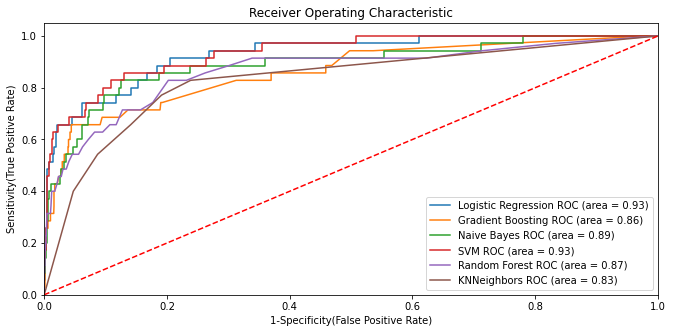

In [47]:
grid = {}
ROC_overlap(models_untuned, grid)

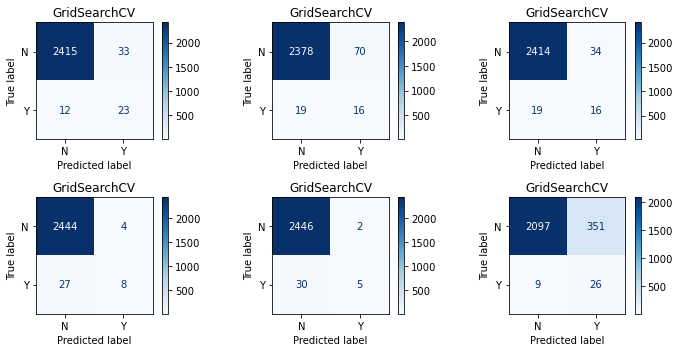

In [48]:
from sklearn.metrics import confusion_matrix
import seaborn as sns
from sklearn.metrics import plot_confusion_matrix
param_grid = {}
allModels = []
for m in models_untuned:
    model = m['model'] # select the model
    over = RandomOverSampler(sampling_strategy=0.1)
    under = RandomUnderSampler(sampling_strategy=0.5)
    steps = [('o', over), ('u', under), ('m', model)]
    pipeline = Pipeline(steps=steps)
    cv = RepeatedStratifiedKFold(n_splits=10, n_repeats=3, random_state=0)
    model = GridSearchCV(pipeline, param_grid, scoring='roc_auc', cv=cv)
    model.fit(X_train, y_train) # train the model
    allModels.append(model)
fig, axes = plt.subplots(nrows=2, ncols=3, figsize=(10,5))

for cls, ax in zip(allModels, axes.flatten()):
    plot_confusion_matrix(cls, 
                          X_test, 
                          y_test, 
                          ax=ax, 
                          cmap='Blues',
                         )
    ax.title.set_text(type(cls).__name__)
plt.tight_layout()  
plt.show()

### Tune Logistic Regression

In [24]:
# Logistic Regression Grid

solvers = ['newton-cg', 'lbfgs', 'liblinear', 'sag']
penalty = ['l2', 'l2', 'elasticnet', 'none']
c_values = [ 0.001, 0.01, 0.1, 1]
class_weight = ['balanced']
max_iter = [ 4000]
LG_grid = {
    'm__solver': solvers,
    'm__penalty': penalty,
    'm__class_weight' : class_weight,
    'm__C': c_values,
    'm__max_iter': max_iter
}
score, model = fit_models(LogisticRegression(), LG_grid )
print(model.best_params_)

{'m__C': 1, 'm__class_weight': 'balanced', 'm__max_iter': 4000, 'm__penalty': 'l2', 'm__solver': 'sag'}


In [ ]:

solvers = ['lbfgs']
penalty = ['l2']
c_values = [1]
class_weight = ['balanced']
max_iter = [ 4000]
LG_grid = {
    'm__solver': solvers,
    'm__penalty': penalty,
    'm__class_weight' : class_weight,
    'm__C': c_values,
    'm__max_iter': max_iter
}
first_auc_scores = ROC_overlap(models_untuned) # store the scores for comparison later

### Confusion Matrix: method 

In [ ]:
# Plots confusion matrix of model

from sklearn.metrics import confusion_matrix
import seaborn as sns

def plotConfusion(models):
    for m in models:
        model = m['model'] # select the model
        model.fit(X_ROS, y_ROS)
        prediction = model.predict(X_test)
        mat = confusion_matrix(y_test, prediction)
        sns.heatmap(mat.T, square=True, annot=True, fmt='d', cbar=False)
        plt.title(m['label'])
        plt.xlabel('true')
        plt.ylabel('predicted')
        plt.show()

In [ ]:
from sklearn.metrics import confusion_matrix
import seaborn as sns
from sklearn.metrics import plot_confusion_matrix

allModels = []
for m in models_untuned:
    model = m['model'] # select the model
    model.fit(X_ROS, y_ROS)
    allModels.append(model)


fig, axes = plt.subplots(nrows=2, ncols=3, figsize=(10,5))

for cls, ax in zip(allModels, axes.flatten()):
    plot_confusion_matrix(cls, 
                          X_test, 
                          y_test, 
                          ax=ax, 
                          cmap='Blues',
                         )
    ax.title.set_text(type(cls).__name__)
plt.tight_layout()  
plt.show()

### Hyperparameter Tuning: Method

In [ ]:
from sklearn.model_selection import GridSearchCV, KFold


def parameter_tuning(model, param_grid):

        # Specify folds for GridSearch
    kf = KFold(n_splits=2, shuffle=False)
        # Run Gridsearch, fit - predict
    grid = GridSearchCV(estimator = model, param_grid=param_grid, scoring='roc_auc', cv=kf)
    grid.fit(X_ROS, y_ROS)
    return grid.best_params_, grid.score(X_test, y_test)

### Tune each model: collect parameters

In [ ]:
# Logistic Regression Grid

solvers = ['newton-cg', 'lbfgs', 'liblinear', 'sag']
penalty = ['l2']
c_values = [0.001, 0.01, 0.1, 1, 10]
LG_grid = {
    'solver': solvers,
    'penalty': penalty,
    'C': c_values
}

In [ ]:
# Gradient Boosting Grid

loss = ['deviance', 'exponential']
lr = [0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9, 1]
ne = range(1, 100, 5)
cr = ['friedman_mse', 'mse', 'mae']
GB_grid = {
    'loss': loss,
    'learning_rate': lr,
    'n_estimators': ne,
    'criterion': cr
}

In [ ]:
# Naive Bayes Grid

alphas = np.arange(1000, 3500, 100)

NB_grid = {
    'alphas' : alphas
}

In [ ]:
# SVM Grid

SVM_grid = {
    'C': [0.1, 1, 10, 100, 1000],
    'gamma': [1, 0.1, 0.01, 0.001, 0.0001],
    'kernel': ['rbf']
}

In [ ]:
# Random Forest Grid

RF_grid = {
    'n_estimators': [1, 2, 4, 8, 16, 32, 64, 100, 200],
    'max_depth': range(1, 32, 1),
    'min_samples_leaf': [1, 2, 3, 4, 5],
    'criterion': ['gini', 'entropy']
}

In [ ]:
# KNN Grid

KNN_grid = {
    'algorithm': ['auto'],
    'leaf_size': [1, 5, 10, 15, 20, 25, 30],
    'n_neighbors': [1, 2, 3, 4, 5, 6, 7, 8],
    'p': [1, 2],
    'weights': ['uniform', 'distance']
}

In [ ]:
LG_best_params, score = parameter_tuning(LogisticRegression(), LG_grid)

In [ ]:
print(LG_best_params, score)

In [ ]:
GB_best_params, score = parameter_tuning(GradientBoostingClassifier(), GB_grid)


In [ ]:
print(GB_best_params, score)

In [ ]:
NB_best_params, score = parameter_tuning(MultinomialNB(), NB_grid)


In [ ]:
print(NB_best_params, score)

In [ ]:
SVM_best_params, score = parameter_tuning(svm.SVC(), SVM_grid)


In [ ]:
RF_best_params, score = parameter_tuning(RandomForestClassifier(), RF_grid)


In [ ]:
KNN_best_params, score = parameter_tuning(KNeighborsClassifier(), KNN_grid)

In [ ]:
print(rf_best_params)

In [ ]:
    # Models after hyperparameters tuned
models_tuned = [
{
    'label': 'Logistic Regression',
    'model': LogisticRegression()
},
{
    'label': 'Gradient Boosting',
    'model': GradientBoostingClassifier(),
},
{
    'label' : 'Naive Bayes',
    'model' : MultinomialNB()
},
{
    'label' : 'SVM',
    'model' : svm.SVC(C=1.0, kernel='linear', degree=3, gamma='auto')
},
{
    'label' : 'Random Forest',
    'model' : RandomForestClassifier(criterion = 'entropy', max_depth = 31, min_samples_leaf = 1,n_estimators = 200)
},
{
    'label' : 'KNNeighbors',
    'model' : KNeighborsClassifier()
}
]

In [ ]:
tuned_auc_scores = ROC_overlap(models_tuned)